In [1]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.models import mobilenet_v3_large

In [2]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [3]:
model = load_model('../saved_models/mobilevit__512_full_mixed_data_17_05_23.pt')

NameError: name 'load_model' is not defined

In [3]:
_C = CN()

_C.ROOT_PATH = "../data"
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 750
_C.IMAGE_H = 750
_C.MEAN = [0.4649, 0.4426, 0.4149]
_C.VAR = [0.2830, 0.2772, 0.2891]

In [4]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


In [5]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [6]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [7]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img) 
        
        label = img_path.split('/')[3].split('_')
        if 'clear_gt' in img_path:
            encoded_label = torch.Tensor([0,0,0,0])
        else:
            encoded_label = encode_label(label)
        
        return img, encoded_label, encode_label(label)

A function, that lists all images contained in the folder.

In [8]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [9]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor()])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor()])

In [10]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

30213
7629


Label: clear
mask: blur

tensor([0., 0., 0., 0.])
../data/train/blur/clear_gt/real_blur/gt_197.png


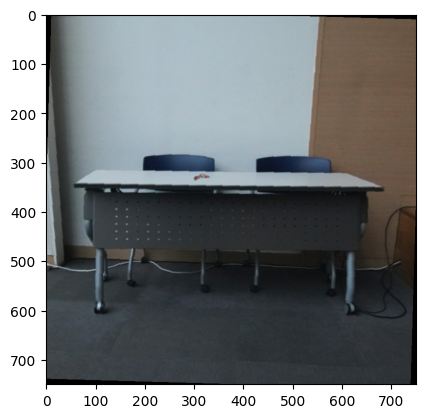

In [11]:
def show_example(img, label, mask):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print("mask:", decode_target(mask))
  print()
  print(label)

show_example(*train_dataset[5000])
print(train_dataset.im_path(5000))

Label: clear
mask: demoir

tensor([0., 0., 0., 0.])


'../data/test/demoir/clear_gt/image_374.jpg'

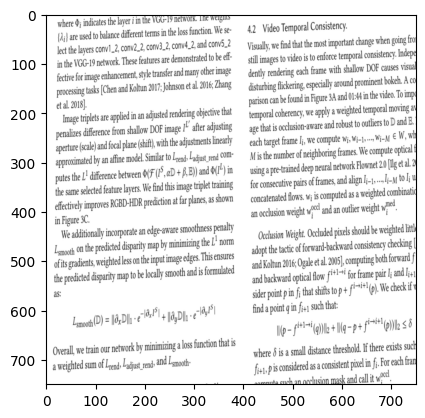

In [12]:
show_example(*val_dataset[3350])
val_dataset.im_path(3350)

In [13]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [14]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, mask, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [15]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [16]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

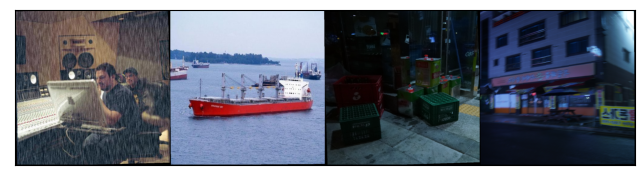

In [17]:
def show_batch(dl, nmax=16):
    for images, labels, masks in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [18]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [19]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [20]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [21]:
images, targets, masks = next(iter(val_loader))
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(1.), tensor(0.7500), tensor(0.8571))


In [22]:
def BCE_custom(preds, targets, masks):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, mask in enumerate(masks):
        for j, val in enumerate(mask):
            if val == 0:
                losses[i][j] == 0
    return losses.mean()

In [23]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets, masks = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets, masks)   # Calculate loss
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets, masks = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets, masks)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del masks
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [25]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [26]:
# checking up the shapes of the datas
for xb, yb, masks in train_dl:
  print(xb.shape)
  print(masks.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 750, 750])
torch.Size([4, 4])
torch.Size([4, 4])


In [27]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [29]:
class CustomModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = mobilenet_v3_large(pretrained=True)
        self.model.classifier = nn.Sequential(
          nn.Linear(960, 512),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, 4)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        out = torch.sigmoid(out)
        return out

In [30]:
model = CustomModel().to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

/home/berezerker/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/berezerker/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


640068

In [31]:
#checking the shape of outputs that the model will produce before starting the training process
for images, masks, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 750, 750])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.5234, 0.4932, 0.4688, 0.5016],
        [0.5225, 0.5016, 0.4709, 0.5016]], device='cuda:0')


In [32]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(505413632, 14628352)

In [33]:
epochs = 10
max_lr = 0.001
grad_clip = 0.8
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [34]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.12976799056232793, rec 0.999999999999999, f2 0.22972502610491316
demoir
prec 0.7619047619047438, rec 0.031999999999999966, f2 0.061420345489365896
haze
prec 0.0, rec 0.0, f2 0.0
rain
prec 0.13456953642384104, rec 0.9931573802541535, f2 0.2370232124108477


[{'val_loss': 0.6899110078811646,
  'val_score': 0.20973551507633012,
  'val_score_blur': 0.22972502610491316,
  'val_score_haze': 0.0,
  'val_score_rain': 0.2370232124108477,
  'val_score_demoir': 0.061420345489365896}]

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9988687782805419, rec 0.891919191919191, f2 0.9423692636067577
demoir
prec 0.9010695187165763, rec 0.6739999999999993, f2 0.7711670480544293
haze
prec 0.9981884057971007, rec 0.9183333333333327, f2 0.9565972222217224
rain
prec 0.9768844221105517, rec 0.9501466275659814, f2 0.9633300297319074
Epoch [0], last_lr: 0.0003, train_loss: 0.2248, val_loss: 0.0603, val_score: 0.9141, val_score_blur: 0.9424, val_score_demoir: 0.7712, val_score_haze: 0.9566, val_score_rain: 0.9633


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.99284984678243, rec 0.9818181818181808, f2 0.9873031995932013
demoir
prec 0.8721881390593038, rec 0.8529999999999991, f2 0.8624873609701765
haze
prec 0.996481970096745, rec 0.9441666666666659, f2 0.969619169875409
rain
prec 0.95066413662239, rec 0.9794721407624624, f2 0.9648531535864033
Epoch [1], last_lr: 0.0008, train_loss: 0.1366, val_loss: 0.0373, val_score: 0.9473, val_score_blur: 0.9873, val_score_demoir: 0.8625, val_score_haze: 0.9696, val_score_rain: 0.9649


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9761431411530805, rec 0.9919191919191909, f2 0.9839679358712425
demoir
prec 0.929032258064515, rec 0.7199999999999993, f2 0.8112676056333099
haze
prec 0.9981583793738481, rec 0.9033333333333327, f2 0.9483814523179606
rain
prec 0.894409937888198, rec 0.9853372434017585, f2 0.9376744186041516
Epoch [2], last_lr: 0.0010, train_loss: 0.1287, val_loss: 0.0470, val_score: 0.9246, val_score_blur: 0.9840, val_score_demoir: 0.8113, val_score_haze: 0.9484, val_score_rain: 0.9377


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9916492693110637, rec 0.9595959595959586, f2 0.9753593429153101
demoir
prec 0.9873417721518962, rec 0.3899999999999996, f2 0.5591397849458297
haze
prec 0.9955396966993747, rec 0.9299999999999993, f2 0.9616544592842908
rain
prec 0.8292483660130713, rec 0.9921798631476041, f2 0.9034267912767617
Epoch [3], last_lr: 0.0010, train_loss: 0.1187, val_loss: 0.0640, val_score: 0.8775, val_score_blur: 0.9754, val_score_demoir: 0.5591, val_score_haze: 0.9617, val_score_rain: 0.9034


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9031078610603284, rec 0.997979797979797, f2 0.9481765834927826
demoir
prec 0.9401595744680838, rec 0.7069999999999993, f2 0.8070776255702853
haze
prec 0.9970930232558131, rec 0.8574999999999994, f2 0.9220430107521903
rain
prec 0.9831013916500984, rec 0.9667644183773206, f2 0.9748644652533186
Epoch [4], last_lr: 0.0008, train_loss: 0.1086, val_loss: 0.0506, val_score: 0.9171, val_score_blur: 0.9482, val_score_demoir: 0.8071, val_score_haze: 0.9220, val_score_rain: 0.9749


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9869739478957906, rec 0.9949494949494939, f2 0.9909456740437645
demoir
prec 0.9344262295081956, rec 0.7979999999999992, f2 0.8608414239477222
haze
prec 0.9972247918593886, rec 0.8983333333333327, f2 0.94519947391445
rain
prec 0.9889336016096569, rec 0.9608993157380245, f2 0.9747149231526969
Epoch [5], last_lr: 0.0006, train_loss: 0.0994, val_loss: 0.0362, val_score: 0.9445, val_score_blur: 0.9909, val_score_demoir: 0.8608, val_score_haze: 0.9452, val_score_rain: 0.9747


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9948665297741263, rec 0.9787878787878778, f2 0.9867617107937963
demoir
prec 0.9341801385681282, rec 0.8089999999999992, f2 0.8670953912106484
haze
prec 0.9999999999999992, rec 0.9249999999999993, f2 0.9610389610384611
rain
prec 0.959692898272552, rec 0.9775171065493636, f2 0.9685230024208067
Epoch [6], last_lr: 0.0004, train_loss: 0.0911, val_loss: 0.0350, val_score: 0.9477, val_score_blur: 0.9868, val_score_demoir: 0.8671, val_score_haze: 0.9610, val_score_rain: 0.9685


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9800598205383838, rec 0.9929292929292919, f2 0.9864525840436534
demoir
prec 0.9582806573957005, rec 0.7579999999999992, f2 0.8464544946952065
haze
prec 0.9982486865148854, rec 0.9499999999999993, f2 0.9735269000848966
rain
prec 0.9463781749764808, rec 0.9833822091886598, f2 0.9645254074779269
Epoch [7], last_lr: 0.0002, train_loss: 0.0819, val_loss: 0.0344, val_score: 0.9467, val_score_blur: 0.9865, val_score_demoir: 0.8465, val_score_haze: 0.9735, val_score_rain: 0.9645


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9929078014184387, rec 0.9898989898989888, f2 0.9914011127966663
demoir
prec 0.9610062893081749, rec 0.7639999999999992, f2 0.851253481893656
haze
prec 0.999103139013452, rec 0.9283333333333327, f2 0.9624190064789815
rain
prec 0.9572649572649564, rec 0.9853372434017585, f2 0.9710982658954529
Epoch [8], last_lr: 0.0000, train_loss: 0.0708, val_loss: 0.0343, val_score: 0.9472, val_score_blur: 0.9914, val_score_demoir: 0.8513, val_score_haze: 0.9624, val_score_rain: 0.9711


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9899091826437931, rec 0.9909090909090899, f2 0.9904088844013161
demoir
prec 0.9578313253012036, rec 0.7949999999999992, f2 0.8688524590158966
haze
prec 0.998204667863554, rec 0.926666666666666, f2 0.9611063094204161
rain
prec 0.9571428571428563, rec 0.9824046920821105, f2 0.9696092619387177
Epoch [9], last_lr: 0.0000, train_loss: 0.0665, val_loss: 0.0337, val_score: 0.9497, val_score_blur: 0.9904, val_score_demoir: 0.8689, val_score_haze: 0.9611, val_score_rain: 0.9696
CPU times: user 55min 46s, sys: 13min 16s, total: 1h 9min 3s
Wall time: 1h 29min 27s


In [36]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay,
                         grad_clip=grad_clip,
                         opt_func=opt_func)

  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9917780061664944, rec 0.9747474747474737, f2 0.9831889964335285
demoir
prec 0.9690576652601955, rec 0.6889999999999993, f2 0.8053769725301971
haze
prec 0.9999999999999991, rec 0.8608333333333327, f2 0.9252127183156685
rain
prec 0.9517045454545446, rec 0.9824046920821105, f2 0.966810966810466
Epoch [0], last_lr: 0.0003, train_loss: 0.0698, val_loss: 0.0419, val_score: 0.9246, val_score_blur: 0.9832, val_score_demoir: 0.8054, val_score_haze: 0.9252, val_score_rain: 0.9668


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9878665318503529, rec 0.9868686868686859, f2 0.9873673572506358
demoir
prec 0.964577656675748, rec 0.7079999999999993, f2 0.8166089965393032
haze
prec 0.995762711864406, rec 0.979166666666666, f2 0.9873949579826925
rain
prec 0.9616858237547884, rec 0.9814271749755611, f2 0.9714562167387347
Epoch [1], last_lr: 0.0008, train_loss: 0.0869, val_loss: 0.0357, val_score: 0.9471, val_score_blur: 0.9874, val_score_demoir: 0.8166, val_score_haze: 0.9874, val_score_rain: 0.9715


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9462055715658013, rec 0.9949494949494939, f2 0.9699655342190956
demoir
prec 0.9547945205479439, rec 0.6969999999999993, f2 0.8057803468203204
haze
prec 0.996578272027373, rec 0.9708333333333325, f2 0.9835373575343241
rain
prec 0.8827646544181971, rec 0.9863147605083079, f2 0.9316712834713382
Epoch [2], last_lr: 0.0010, train_loss: 0.1036, val_loss: 0.0426, val_score: 0.9296, val_score_blur: 0.9700, val_score_demoir: 0.8058, val_score_haze: 0.9835, val_score_rain: 0.9317


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9928934010152274, rec 0.9878787878787869, f2 0.990379746834942
demoir
prec 0.9582689335394111, rec 0.6199999999999993, f2 0.7528840315720781
haze
prec 0.9974789915966379, rec 0.989166666666666, f2 0.9933054393300432
rain
prec 0.915607985480943, rec 0.9863147605083079, f2 0.9496470588230292
Epoch [3], last_lr: 0.0010, train_loss: 0.1106, val_loss: 0.0424, val_score: 0.9325, val_score_blur: 0.9904, val_score_demoir: 0.7529, val_score_haze: 0.9933, val_score_rain: 0.9496


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9879154078549839, rec 0.9909090909090899, f2 0.9894099848709058
demoir
prec 0.9654676258992791, rec 0.6709999999999993, f2 0.7917404129788662
haze
prec 0.9955830388692571, rec 0.9391666666666659, f2 0.966552315608419
rain
prec 0.9616519174041288, rec 0.9560117302052776, f2 0.9588235294112637
Epoch [4], last_lr: 0.0008, train_loss: 0.1032, val_loss: 0.0452, val_score: 0.9334, val_score_blur: 0.9894, val_score_demoir: 0.7917, val_score_haze: 0.9666, val_score_rain: 0.9588


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9938587512794258, rec 0.9808080808080798, f2 0.987290289780892
demoir
prec 0.974522292993629, rec 0.6119999999999993, f2 0.7518427518422769
haze
prec 0.9974554707379127, rec 0.9799999999999992, f2 0.9886506935682257
rain
prec 0.989989989989989, rec 0.9667644183773206, f2 0.9782393669629016
Epoch [5], last_lr: 0.0006, train_loss: 0.0945, val_loss: 0.0381, val_score: 0.9375, val_score_blur: 0.9873, val_score_demoir: 0.7518, val_score_haze: 0.9887, val_score_rain: 0.9782


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.983016983016982, rec 0.9939393939393929, f2 0.9884480160718244
demoir
prec 0.9659090909090895, rec 0.6799999999999993, f2 0.7981220657272137
haze
prec 0.9999999999999991, rec 0.9099999999999994, f2 0.9528795811513329
rain
prec 0.934014869888475, rec 0.9824046920821105, f2 0.9575988565978796
Epoch [6], last_lr: 0.0004, train_loss: 0.0864, val_loss: 0.0444, val_score: 0.9302, val_score_blur: 0.9884, val_score_demoir: 0.7981, val_score_haze: 0.9529, val_score_rain: 0.9576


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9859437751004005, rec 0.9919191919191909, f2 0.9889224571999017
demoir
prec 0.9665775401069505, rec 0.7229999999999993, f2 0.827231121280974
haze
prec 0.9974093264248697, rec 0.9624999999999992, f2 0.9796437659028072
rain
prec 0.9682080924855483, rec 0.9824046920821105, f2 0.975254730712745
Epoch [7], last_lr: 0.0002, train_loss: 0.0766, val_loss: 0.0345, val_score: 0.9481, val_score_blur: 0.9889, val_score_demoir: 0.8272, val_score_haze: 0.9796, val_score_rain: 0.9753


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9869083585095659, rec 0.9898989898989888, f2 0.988401412001516
demoir
prec 0.962264150943395, rec 0.7649999999999992, f2 0.8523676880217897
haze
prec 0.9999999999999992, rec 0.921666666666666, f2 0.9592367736334985
rain
prec 0.9535545023696674, rec 0.9833822091886598, f2 0.9682386910485848
Epoch [8], last_lr: 0.0000, train_loss: 0.0678, val_loss: 0.0351, val_score: 0.9451, val_score_blur: 0.9884, val_score_demoir: 0.8524, val_score_haze: 0.9592, val_score_rain: 0.9682


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9849397590361436, rec 0.9909090909090899, f2 0.987915407854484
demoir
prec 0.9537366548042693, rec 0.8039999999999992, f2 0.8724905046115481
haze
prec 0.9991181657848317, rec 0.9441666666666659, f2 0.9708654670089254
rain
prec 0.962715105162523, rec 0.9843597262952092, f2 0.9734171097143371
Epoch [9], last_lr: 0.0000, train_loss: 0.0645, val_loss: 0.0312, val_score: 0.9536, val_score_blur: 0.9879, val_score_demoir: 0.8725, val_score_haze: 0.9709, val_score_rain: 0.9734


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9899091826437931, rec 0.9909090909090899, f2 0.9904088844013161
demoir
prec 0.9678770949720656, rec 0.6929999999999993, f2 0.8076923076918203
haze
prec 0.9999999999999991, rec 0.904166666666666, f2 0.9496717724283845
rain
prec 0.9628217349856998, rec 0.9872922776148573, f2 0.974903474902974
Epoch [0], last_lr: 0.0003, train_loss: 0.0681, val_loss: 0.0415, val_score: 0.9359, val_score_blur: 0.9904, val_score_demoir: 0.8077, val_score_haze: 0.9497, val_score_rain: 0.9749


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9820538384845453, rec 0.9949494949494939, f2 0.9884596086297046
demoir
prec 0.9600499375780263, rec 0.7689999999999992, f2 0.8539700166569177
haze
prec 0.9974640743871506, rec 0.9833333333333326, f2 0.9903483004611023
rain
prec 0.9543726235741437, rec 0.9814271749755611, f2 0.9677108433729931
Epoch [1], last_lr: 0.0008, train_loss: 0.0833, val_loss: 0.0322, val_score: 0.9544, val_score_blur: 0.9885, val_score_demoir: 0.8540, val_score_haze: 0.9903, val_score_rain: 0.9677


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9958634953464313, rec 0.9727272727272718, f2 0.9841594276949511
demoir
prec 0.9546632124352319, rec 0.7369999999999992, f2 0.8318284424374305
haze
prec 0.9999999999999992, rec 0.9183333333333327, f2 0.95742832319672
rain
prec 0.9989615784008297, rec 0.9403714565004878, f2 0.9687814702915438
Epoch [2], last_lr: 0.0010, train_loss: 0.0995, val_loss: 0.0407, val_score: 0.9390, val_score_blur: 0.9842, val_score_demoir: 0.8318, val_score_haze: 0.9574, val_score_rain: 0.9688


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9939086294416233, rec 0.9888888888888878, f2 0.99139240506279
demoir
prec 0.9034907597535925, rec 0.8799999999999991, f2 0.8915906788242205
haze
prec 0.9982222222222215, rec 0.9358333333333326, f2 0.9660215053758439
rain
prec 0.9754420432220029, rec 0.9706744868035181, f2 0.9730524252812237
Epoch [3], last_lr: 0.0010, train_loss: 0.1048, val_loss: 0.0320, val_score: 0.9561, val_score_blur: 0.9914, val_score_demoir: 0.8916, val_score_haze: 0.9660, val_score_rain: 0.9731


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9810568295114646, rec 0.9939393939393929, f2 0.9874560963366791
demoir
prec 0.9544303797468342, rec 0.7539999999999992, f2 0.8424581005581651
haze
prec 0.9991243432574423, rec 0.9508333333333326, f2 0.9743808710498838
rain
prec 0.9680542110358171, rec 0.9775171065493636, f2 0.9727626459138959
Epoch [4], last_lr: 0.0008, train_loss: 0.1007, val_loss: 0.0341, val_score: 0.9483, val_score_blur: 0.9875, val_score_demoir: 0.8425, val_score_haze: 0.9744, val_score_rain: 0.9728


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9979013641133253, rec 0.9606060606060596, f2 0.9788986103957935
demoir
prec 0.9277522935779806, rec 0.8089999999999992, f2 0.8643162393157406
haze
prec 0.9982409850483721, rec 0.9458333333333326, f2 0.9713307659387379
rain
prec 0.9591254752851702, rec 0.9863147605083079, f2 0.9725301204814268
Epoch [5], last_lr: 0.0006, train_loss: 0.0920, val_loss: 0.0329, val_score: 0.9491, val_score_blur: 0.9789, val_score_demoir: 0.8643, val_score_haze: 0.9713, val_score_rain: 0.9725


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9938837920489286, rec 0.9848484848484839, f2 0.9893455098929541
demoir
prec 0.9331823329558313, rec 0.8239999999999992, f2 0.8751991502915881
haze
prec 0.9999999999999991, rec 0.9074999999999993, f2 0.9515072083874427
rain
prec 0.9397590361445776, rec 0.9912023460410547, f2 0.9647954329205269
Epoch [6], last_lr: 0.0004, train_loss: 0.0849, val_loss: 0.0365, val_score: 0.9465, val_score_blur: 0.9893, val_score_demoir: 0.8752, val_score_haze: 0.9515, val_score_rain: 0.9648


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9889224572004018, rec 0.9919191919191909, f2 0.9904185577402957
demoir
prec 0.9574999999999988, rec 0.7659999999999992, f2 0.8511111111106163
haze
prec 0.9991150442477869, rec 0.9408333333333326, f2 0.9690987124458516
rain
prec 0.9429906542056067, rec 0.9863147605083079, f2 0.9641662685135939
Epoch [7], last_lr: 0.0002, train_loss: 0.0737, val_loss: 0.0330, val_score: 0.9471, val_score_blur: 0.9904, val_score_demoir: 0.8511, val_score_haze: 0.9691, val_score_rain: 0.9642


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9879154078549839, rec 0.9909090909090899, f2 0.9894099848709058
demoir
prec 0.9633986928104562, rec 0.7369999999999992, f2 0.8351274787530488
haze
prec 0.9991119005328589, rec 0.9374999999999993, f2 0.9673258813408584
rain
prec 0.9536423841059595, rec 0.9853372434017585, f2 0.9692307692302685
Epoch [8], last_lr: 0.0000, train_loss: 0.0681, val_loss: 0.0362, val_score: 0.9446, val_score_blur: 0.9894, val_score_demoir: 0.8351, val_score_haze: 0.9673, val_score_rain: 0.9692


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9888663967611325, rec 0.9868686868686859, f2 0.9878665318498527
demoir
prec 0.9589041095890398, rec 0.7699999999999992, f2 0.8541320022180295
haze
prec 0.9991079393398743, rec 0.9333333333333326, f2 0.9651012494609387
rain
prec 0.963601532567049, rec 0.9833822091886598, f2 0.9733913884852272
Epoch [9], last_lr: 0.0000, train_loss: 0.0635, val_loss: 0.0333, val_score: 0.9482, val_score_blur: 0.9879, val_score_demoir: 0.8541, val_score_haze: 0.9651, val_score_rain: 0.9734


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.983999999999999, rec 0.9939393939393929, f2 0.9889447236175893
demoir
prec 0.9421487603305774, rec 0.7979999999999992, f2 0.864103952354673
haze
prec 0.9991166077738508, rec 0.9424999999999993, f2 0.9699828473408375
rain
prec 0.9345622119815661, rec 0.9912023460410547, f2 0.9620493358628771
Epoch [0], last_lr: 0.0003, train_loss: 0.0675, val_loss: 0.0340, val_score: 0.9489, val_score_blur: 0.9889, val_score_demoir: 0.8641, val_score_haze: 0.9700, val_score_rain: 0.9620


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9569471624266135, rec 0.9878787878787869, f2 0.9721669980114276
demoir
prec 0.9037487335359666, rec 0.8919999999999991, f2 0.8978359335676922
haze
prec 0.9991173874669013, rec 0.9433333333333326, f2 0.9704243463346904
rain
prec 0.9637058261700087, rec 0.9863147605083079, f2 0.9748792270526392
Epoch [1], last_lr: 0.0008, train_loss: 0.0821, val_loss: 0.0349, val_score: 0.9548, val_score_blur: 0.9722, val_score_demoir: 0.8978, val_score_haze: 0.9704, val_score_rain: 0.9749


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9908906882591083, rec 0.9888888888888878, f2 0.9898887765414603
demoir
prec 0.9596879063719103, rec 0.7379999999999992, f2 0.8343697003952113
haze
prec 0.9921465968586379, rec 0.9474999999999992, f2 0.9693094629151005
rain
prec 0.9607072691552053, rec 0.9560117302052776, f2 0.9583537481621643
Epoch [2], last_lr: 0.0010, train_loss: 0.0990, val_loss: 0.0366, val_score: 0.9422, val_score_blur: 0.9899, val_score_demoir: 0.8344, val_score_haze: 0.9693, val_score_rain: 0.9584


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9999999999999989, rec 0.9272727272727264, f2 0.962264150942896
demoir
prec 0.9759999999999984, rec 0.6099999999999993, f2 0.7507692307687563
haze
prec 0.997175141242937, rec 0.8824999999999993, f2 0.9363395225459202
rain
prec 0.9979612640163088, rec 0.956989247311827, f2 0.9770459081831319
Epoch [3], last_lr: 0.0010, train_loss: 0.1048, val_loss: 0.0495, val_score: 0.9145, val_score_blur: 0.9623, val_score_demoir: 0.7508, val_score_haze: 0.9363, val_score_rain: 0.9770


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9918864097363073, rec 0.9878787878787869, f2 0.9898785425096205
demoir
prec 0.9365452408930659, rec 0.7969999999999992, f2 0.8611561318201398
haze
prec 0.999999999999999, rec 0.846666666666666, f2 0.9169675090247734
rain
prec 0.9335180055401654, rec 0.9882697947214066, f2 0.9601139601134596
Epoch [4], last_lr: 0.0008, train_loss: 0.1016, val_loss: 0.0441, val_score: 0.9331, val_score_blur: 0.9899, val_score_demoir: 0.8612, val_score_haze: 0.9170, val_score_rain: 0.9601


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9918781725888315, rec 0.9868686868686859, f2 0.989367088607094
demoir
prec 0.9544879898862187, rec 0.7549999999999992, f2 0.8431044109431127
haze
prec 0.9991568296795945, rec 0.9874999999999993, f2 0.9932942162610248
rain
prec 0.9132791327913271, rec 0.9882697947214066, f2 0.9492957746473872
Epoch [5], last_lr: 0.0006, train_loss: 0.0929, val_loss: 0.0369, val_score: 0.9486, val_score_blur: 0.9894, val_score_demoir: 0.8431, val_score_haze: 0.9933, val_score_rain: 0.9493


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9742063492063482, rec 0.9919191919191909, f2 0.982982982982482
demoir
prec 0.9487836107554405, rec 0.7409999999999992, f2 0.8321167883206744
haze
prec 0.9991416309012868, rec 0.9699999999999993, f2 0.9843551797035163
rain
prec 0.9511278195488714, rec 0.989247311827956, f2 0.9698131288926474
Epoch [6], last_lr: 0.0004, train_loss: 0.0866, val_loss: 0.0349, val_score: 0.9474, val_score_blur: 0.9830, val_score_demoir: 0.8321, val_score_haze: 0.9844, val_score_rain: 0.9698


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9899091826437931, rec 0.9909090909090899, f2 0.9904088844013161
demoir
prec 0.956907477820024, rec 0.7549999999999992, f2 0.8440469536048721
haze
prec 0.9999999999999992, rec 0.9133333333333327, f2 0.9547038327521136
rain
prec 0.9528746465598484, rec 0.9882697947214066, f2 0.9702495201530501
Epoch [7], last_lr: 0.0002, train_loss: 0.0762, val_loss: 0.0369, val_score: 0.9431, val_score_blur: 0.9904, val_score_demoir: 0.8440, val_score_haze: 0.9547, val_score_rain: 0.9702


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9909182643794137, rec 0.9919191919191909, f2 0.9914184755169143
demoir
prec 0.9518518518518506, rec 0.7709999999999992, f2 0.851933701656963
haze
prec 0.999103139013452, rec 0.9283333333333327, f2 0.9624190064789815
rain
prec 0.958174904942965, rec 0.9853372434017585, f2 0.9715662650597401
Epoch [8], last_lr: 0.0000, train_loss: 0.0683, val_loss: 0.0337, val_score: 0.9473, val_score_blur: 0.9914, val_score_demoir: 0.8519, val_score_haze: 0.9624, val_score_rain: 0.9716


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9949341438703131, rec 0.9919191919191909, f2 0.9934243803738034
demoir
prec 0.9549330085261863, rec 0.7839999999999993, f2 0.8610653487090042
haze
prec 0.9999999999999992, rec 0.9349999999999993, f2 0.9664082687333498
rain
prec 0.9430970149253723, rec 0.9882697947214066, f2 0.9651551312644158
Epoch [9], last_lr: 0.0000, train_loss: 0.0628, val_loss: 0.0341, val_score: 0.9492, val_score_blur: 0.9934, val_score_demoir: 0.8611, val_score_haze: 0.9664, val_score_rain: 0.9652


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9969072164948443, rec 0.9767676767676757, f2 0.9867346938770499
demoir
prec 0.9343715239154605, rec 0.8399999999999992, f2 0.8846761453391528
haze
prec 0.9999999999999992, rec 0.9616666666666659, f2 0.9804587935424051
rain
prec 0.9673076923076914, rec 0.9833822091886598, f2 0.975278720309727
Epoch [0], last_lr: 0.0003, train_loss: 0.0673, val_loss: 0.0292, val_score: 0.9587, val_score_blur: 0.9867, val_score_demoir: 0.8847, val_score_haze: 0.9805, val_score_rain: 0.9753


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9791252485089453, rec 0.9949494949494939, f2 0.9869739478952906
demoir
prec 0.9687987519500765, rec 0.6209999999999993, f2 0.7568555758678959
haze
prec 0.9999999999999992, rec 0.9358333333333326, f2 0.9668532070593362
rain
prec 0.961904761904761, rec 0.9872922776148573, f2 0.9744331886150323
Epoch [1], last_lr: 0.0008, train_loss: 0.0826, val_loss: 0.0431, val_score: 0.9309, val_score_blur: 0.9870, val_score_demoir: 0.7569, val_score_haze: 0.9669, val_score_rain: 0.9744


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9898373983739827, rec 0.9838383838383828, f2 0.9868287740623155
demoir
prec 0.9267192784667407, rec 0.8219999999999992, f2 0.8712241653413133
haze
prec 0.9899074852817487, rec 0.9808333333333326, f2 0.9853495186265399
rain
prec 0.9500941619585679, rec 0.9863147605083079, f2 0.9678657074335519
Epoch [2], last_lr: 0.0010, train_loss: 0.0982, val_loss: 0.0342, val_score: 0.9555, val_score_blur: 0.9868, val_score_demoir: 0.8712, val_score_haze: 0.9853, val_score_rain: 0.9679


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9760479041916158, rec 0.9878787878787869, f2 0.9819277108428726
demoir
prec 0.9435294117647047, rec 0.8019999999999992, f2 0.8670270270265292
haze
prec 0.9991474850809882, rec 0.9766666666666659, f2 0.9877791824689471
rain
prec 0.9545454545454537, rec 0.9853372434017585, f2 0.9696969696964688
Epoch [3], last_lr: 0.0010, train_loss: 0.1016, val_loss: 0.0325, val_score: 0.9549, val_score_blur: 0.9819, val_score_demoir: 0.8670, val_score_haze: 0.9878, val_score_rain: 0.9697


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9889336016096569, rec 0.9929292929292919, f2 0.9909274193543377
demoir
prec 0.9455621301775137, rec 0.7989999999999992, f2 0.8661246612461149
haze
prec 0.9991111111111103, rec 0.936666666666666, f2 0.9668817204296072
rain
prec 0.8996447602131431, rec 0.9902248289345054, f2 0.9427640763140651
Epoch [4], last_lr: 0.0008, train_loss: 0.1006, val_loss: 0.0361, val_score: 0.9440, val_score_blur: 0.9909, val_score_demoir: 0.8661, val_score_haze: 0.9669, val_score_rain: 0.9428


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.981999999999999, rec 0.9919191919191909, f2 0.9869346733663331
demoir
prec 0.939252336448597, rec 0.8039999999999992, f2 0.8663793103443295
haze
prec 0.9991438356164376, rec 0.9724999999999993, f2 0.9856418918913913
rain
prec 0.8341543513957301, rec 0.9931573802541535, f2 0.9067380633640723
Epoch [5], last_lr: 0.0006, train_loss: 0.0934, val_loss: 0.0421, val_score: 0.9389, val_score_blur: 0.9869, val_score_demoir: 0.8664, val_score_haze: 0.9856, val_score_rain: 0.9067


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9849699398797586, rec 0.9929292929292919, f2 0.9889336016091568
demoir
prec 0.969230769230768, rec 0.7559999999999992, f2 0.8494382022466976
haze
prec 0.9982638888888881, rec 0.9583333333333326, f2 0.9778911564620845
rain
prec 0.9599236641221366, rec 0.9833822091886598, f2 0.9715113471747767
Epoch [6], last_lr: 0.0004, train_loss: 0.0866, val_loss: 0.0327, val_score: 0.9510, val_score_blur: 0.9889, val_score_demoir: 0.8494, val_score_haze: 0.9779, val_score_rain: 0.9715


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9771144278606956, rec 0.9919191919191909, f2 0.9844611528817044
demoir
prec 0.9667093469910358, rec 0.7549999999999992, f2 0.847838293093274
haze
prec 0.9999999999999992, rec 0.9541666666666659, f2 0.9765458422169834
rain
prec 0.9403541472506982, rec 0.9863147605083079, f2 0.9627862595414841
Epoch [7], last_lr: 0.0002, train_loss: 0.0752, val_loss: 0.0346, val_score: 0.9471, val_score_blur: 0.9845, val_score_demoir: 0.8478, val_score_haze: 0.9765, val_score_rain: 0.9628


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9919028340080961, rec 0.9898989898989888, f2 0.9908998988872643
demoir
prec 0.9626400996263997, rec 0.7729999999999992, f2 0.8574597892396603
haze
prec 0.9991296779808522, rec 0.9566666666666659, f2 0.9774372073217643
rain
prec 0.941286113699906, rec 0.9872922776148573, f2 0.9637404580147666
Epoch [8], last_lr: 0.0000, train_loss: 0.0681, val_loss: 0.0331, val_score: 0.9509, val_score_blur: 0.9909, val_score_demoir: 0.8575, val_score_haze: 0.9774, val_score_rain: 0.9637


  0%|          | 0/7554 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9908722109533459, rec 0.9868686868686859, f2 0.9888663967606327
demoir
prec 0.951190476190475, rec 0.7989999999999992, f2 0.868478260869068
haze
prec 0.9999999999999992, rec 0.9499999999999993, f2 0.974358974358474
rain
prec 0.9545454545454537, rec 0.9853372434017585, f2 0.9696969696964688
Epoch [9], last_lr: 0.0000, train_loss: 0.0643, val_loss: 0.0315, val_score: 0.9530, val_score_blur: 0.9889, val_score_demoir: 0.8685, val_score_haze: 0.9744, val_score_rain: 0.9697


In [37]:
evaluate(model, val_dl)

  0%|          | 0/954 [00:00<?, ?it/s]

blur
prec 0.9908722109533459, rec 0.9868686868686859, f2 0.9888663967606327
demoir
prec 0.951190476190475, rec 0.7989999999999992, f2 0.868478260869068
haze
prec 0.9999999999999992, rec 0.9499999999999993, f2 0.974358974358474
rain
prec 0.9545454545454537, rec 0.9853372434017585, f2 0.9696969696964688


{'val_loss': 0.03147820010781288,
 'val_score': 0.9530054644803744,
 'val_score_blur': 0.9888663967606327,
 'val_score_haze': 0.974358974358474,
 'val_score_rain': 0.9696969696964688,
 'val_score_demoir': 0.868478260869068}

Label: clear
mask: blur

tensor([4.6113e-06, 7.2317e-06, 7.1441e-11, 6.3499e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)


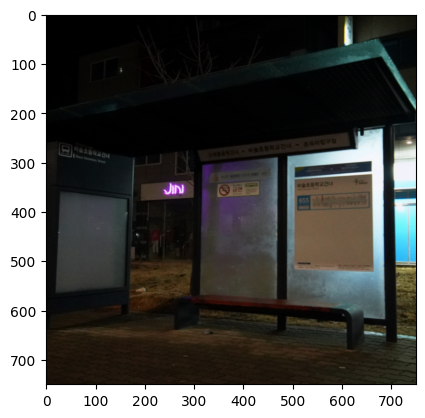

In [57]:
def predict_single(image, label, mask):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, mask)
predict_single(*val_dataset[1497])

In [58]:
val_dataset.im_path(1497)

'../data/test/blur/clear_gt/real_blur/gt_489.png'

In [40]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

8
9
11
30
65
108
112
122
211
218
488
526
548
942
1015
1017
1033
1034
1062
1063
2044
2049
2053
2054
2056
2062
2071
2076
2079
2084
2100
2106
2107
2108
2115
2118
2127
2128
2137
2144
2155
2163
2172
2177
2183
2185
2188
2191
2192
2206
2216
2219
2230
2234
2240
2243
2245
2247
2249
2250
2254
2256
2257
2259
2278
2281
2291
2294
2298
2306
2312
2314
2321
2324
2328
2335
2339
2342
2345
2348
2351
2353
2356
2358
2363
2364
2365
2373
2384
2391
2399
2404
2405
2409
2410
2422
2423
2426
2444
2448
2460
2462
2478
2479
2494
2498
2501
2502
2504
2505
2511
2512
2513
2515
2522
2523
2524
2529
2544
2555
2556
2575
2582
2583
2584
2616
2622
2624
2625
2627
2630
2639
2667
2685
2687
2688
2689
2692
2693
2705
2708
2712
2739
2740
2747
2750
2755
2758
2762
2764
2765
2766
2767
2768
2770
2772
2774
2775
2778
2780
2785
2794
2795
2797
2798
2814
2817
2820
2821
2829
2833
2835
2842
2844
2849
2851
2856
2859
2865
2869
2887
2900
2901
2908
2909
2910
2913
2914
2915
2916
2918
2929
2951
2952
2955
2957
2958
2960
2964
2969
2973
2976
2980
2983
2

Label: demoir
mask: blur

tensor([1.8178e-04, 9.5087e-01, 2.4052e-06, 1.5035e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)


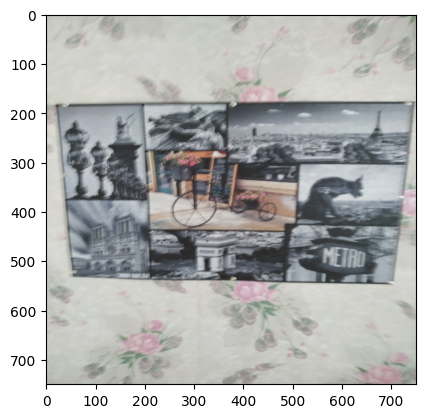

In [64]:
predict_single(*val_dataset[65])

In [42]:
val_dataset.im_path(0)

'../data/test/blur/0_IPHONE-SE_F.JPG'

Label: clear
mask: blur

tensor([0., 0., 0., 0.])


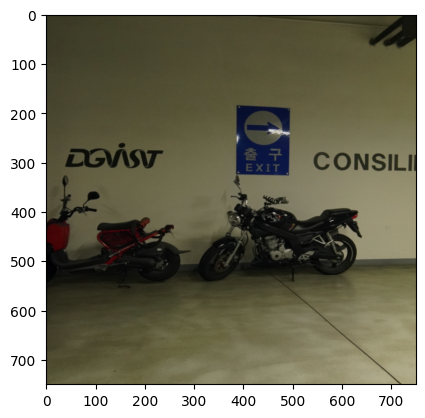

In [43]:
show_example(*val_dataset[1258])

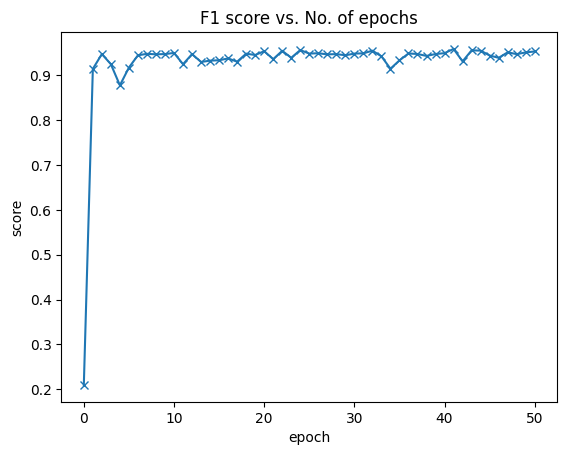

In [44]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

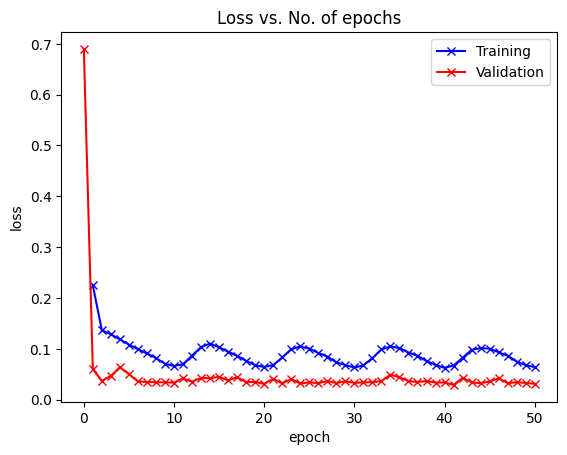

In [45]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

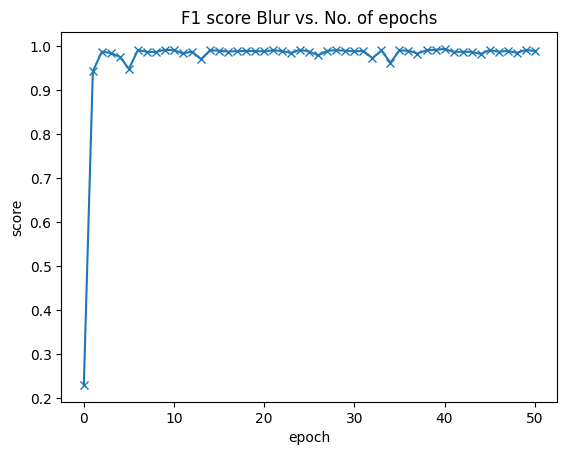

In [46]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

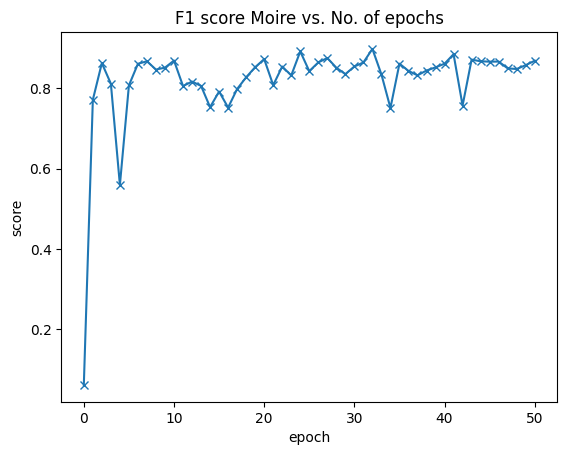

In [47]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

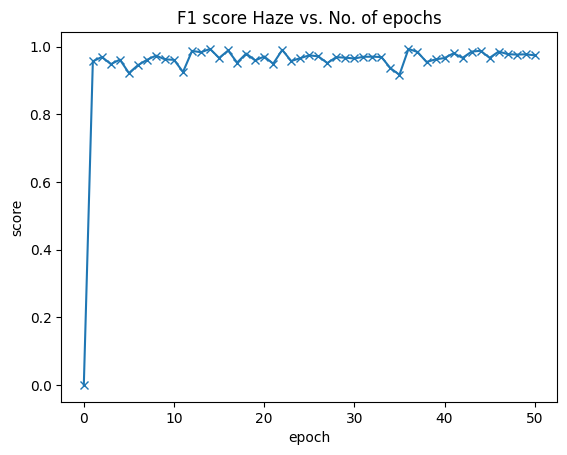

In [48]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

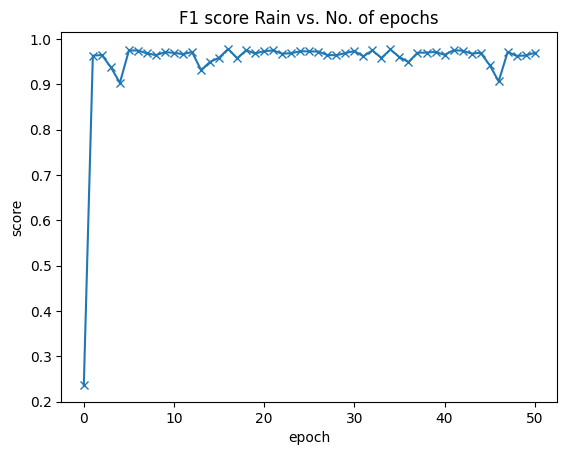

In [49]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

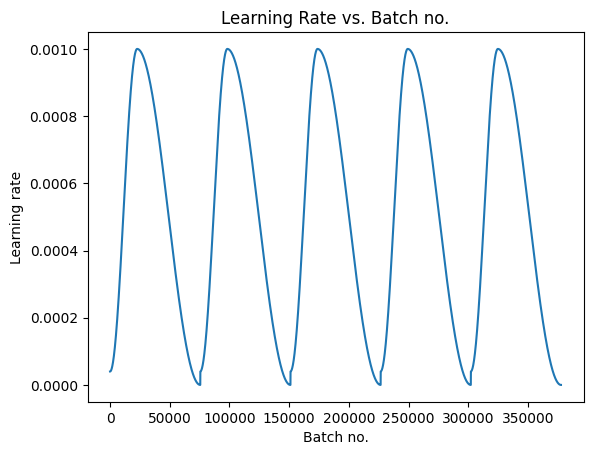

In [50]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [51]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([3.4877e-05, 2.0524e-04, 2.3709e-03, 1.2441e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


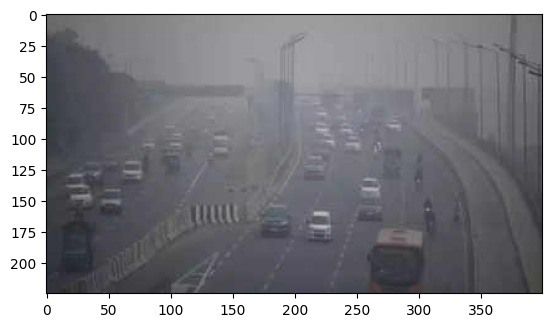

In [52]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([2.9022e-04, 2.8312e-02, 4.3953e-06, 5.5847e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


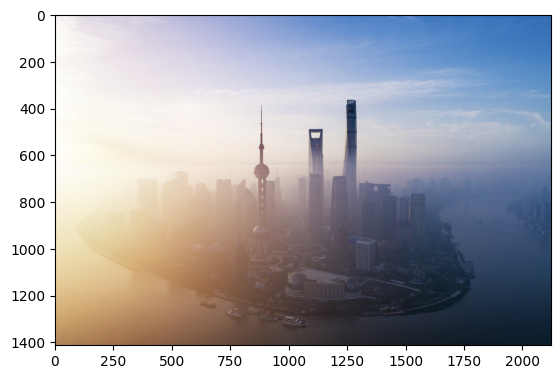

In [53]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([1.2516e-06, 4.6714e-04, 5.5518e-09, 3.9634e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: clear


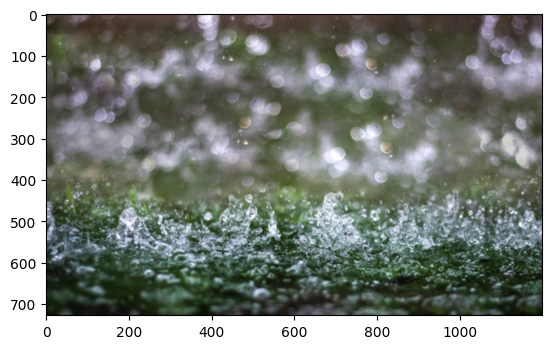

In [54]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

In [ ]:
show_example(*val_dataset[3280]) #checking out the predictions of some images from the validation dataset.

In [65]:
PATH = os.path.join('../saved_models', datetime.now().strftime('mobilenetv3_frozen_750_full_data_14_05_23.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/mobilenetv2_customBCE_new_metrics_not_pretrained_13_05_23.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()